In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd

from src import isingNumba as ising
from src import helperfunctions as hf

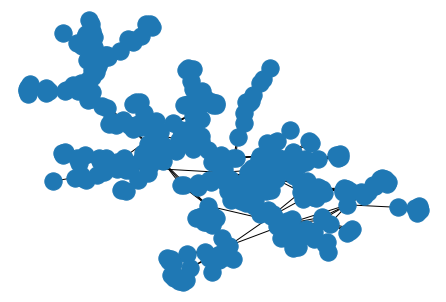

In [2]:
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/real_networks/ca-netscience.txt'


df = pd.read_csv(path, delimiter = " ")

def extract_network(df):

    G = nx.from_pandas_edgelist(df,source='FromNodeId', target='ToNodeId')
    subgraphs=[G.subgraph(c) for c in nx.connected_components(G)]
    subgraphs_sizes = sorted([len(subgraph.nodes) for subgraph in subgraphs])
    
    mapping = {i:k for k,i in enumerate(list(G.nodes))}
    H=nx.relabel_nodes(G,mapping)
    
    return H


G = extract_network(df)

nx.draw(G)



In [23]:
import networkx as nx 
import numpy as np
import math
from numpy.linalg import LinAlgError  
from tqdm import tqdm
import numba
from numba.experimental import jitclass
from numba import jit




steadyspec = [
    ('adj_matrix',numba.float64[:,:]),
    ('graph_size',numba.int32),
    ('background_field',numba.float64[:]),
    ('fixed_point_iter',numba.int32),
    ('fp_tol_fac',numba.float64),
]


@jitclass(steadyspec)
class steady_state(object):
    def __init__(self,adj_matrix,fixed_point_iter=5000,fp_tol_fac=1e-5):

        self.adj_matrix = adj_matrix
        self.graph_size = self.adj_matrix.shape[0]
        self.fixed_point_iter=fixed_point_iter
        self.fp_tol_fac=fp_tol_fac


    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = self.adj_matrix[i].dot(m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term

    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new

    def aitken_method(self,mag0,beta,field):      
        mag1=self.magnetisation(mag0,beta,field)
        for i in range(self.fixed_point_iter):     
            mag2=self.magnetisation(mag1,beta,field)   
            if ((mag0+mag2-2*mag1)!=0).all():
                mag_d = mag0 - (mag1-mag0)**2/(mag0+mag2-2*mag1) 
            else:
                mag_d = mag1

            if abs(np.sum(mag0)-np.sum(mag_d))<self.fp_tol_fac: 
                break
            mag0=mag1
            mag1=mag2
            if i+1==self.fixed_point_iter:
                mag_d = mag1

        return mag_d

@jit(nopython=True) 
def isclose(a,b):
    return abs(a-b) <= max(1e-9 * max(abs(a), abs(b)), 1e-5)


@jit(nopython=True) 
def susc_grad(beta,mag,adj_matrix):
    D=np.identity(mag.shape[0])*np.array([(1-i**2) for i in mag]) 
    inv = np.linalg.inv(np.identity(mag.shape[0])-beta*D.dot(adj_matrix))
    susc_matrix = beta*inv.dot(D)
    gradient = np.sum(susc_matrix,axis=1).flatten()
    gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

    return gradient

def mag_grad(beta,mag,adj_matrix):
    if np.all([isclose(i,j) for i,j in zip(mag,np.ones(mag.shape[0]))]):
        return np.zeros(len(mag))
    else:
        return susc_grad(beta,mag,adj_matrix)




@jit(nopython=True)
def projection_simplex_sort(v, z):
    n_features = v.shape[0]
    v = np.abs(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


@jit(nopython=True) 
def lr_1(x,iim_iter=5000):
    return np.exp(-x/(0.1*iim_iter))

@jit(nopython=True) 
def lr_2(x,iim_iter=5000):
    return np.exp(-x/(0.1*iim_iter))

@jit(nopython=True) 
def adam(grad,it,typ,ms,vs,iim_iter,beta1=0.9,beta2=0.999,eps=0.1):
    if typ=='pos':
        lr=lr_1(it)
    elif typ=='neg':
        lr=lr_2(it)
    ms_new = beta1 * ms + (1.0 - beta1) * grad
    vs_new = beta2 * vs + (1.0 - beta2) * grad**2
    mhat = ms_new / (1.0 - beta1**(it+1))
    vhat = vs_new / (1.0 - beta2**(it+1))
    ms = ms_new
    vs = vs_new
    change = lr* mhat/(np.sqrt(vhat) + eps)
    return change,ms,vs

class mf_ising_system():
    def __init__(self,graph,background_field,iim_iter=10000,iim_tol_fac=1e-3):

        self.graph=graph
        self.adj_matrix = nx.to_numpy_matrix(graph).astype(np.float64)
        self.graph_size = self.adj_matrix.shape[0]
        self.background_field = background_field.astype(np.float64)
        self.iim_iter=iim_iter
        self.iim_tol_fac = iim_tol_fac
        

    def positive_agent(self,mag_i,it,pos_budget,beta):
        mag_i_grad = mag_grad(beta,mag_i,self.adj_matrix)
        control_field = self.control_field_history_pos[-1]
        change,ms,vs = adam(mag_i_grad,it,'pos',self.ms_pos,self.vs_pos,self.iim_iter)
        self.ms_pos=ms
        self.vs_pos=vs
        control_field_update = control_field  + change
        control_field_new = projection_simplex_sort(control_field_update.T,pos_budget)
        self.control_field_history_pos.append(control_field_new)
        return control_field_new,mag_i_grad
    
    def negative_agent(self,mag_i,it,neg_budget,beta):
        mag_i = -1.0*mag_i
        mag_i_grad = -mag_grad(beta,mag_i,self.adj_matrix)
        control_field = self.control_field_history_neg[-1]
        change,ms,vs=adam(mag_i_grad,it,'neg',self.ms_neg,self.vs_neg,self.iim_iter)
        self.ms_neg=ms
        self.vs_neg=vs
        control_field_update = control_field - change
        # TODO: put here aitken method and grad with respect to control_field_update
        control_field_new = projection_simplex_sort(control_field_update.T,neg_budget)
        self.control_field_history_neg.append(control_field_new)
        
        return control_field_new,mag_i_grad
        
    def second_partial_dffs(self,state,mag_ii,tot_field,beta,a=1e-5):
        update = a*np.ones(self.graph_size)
        upper_change=tot_field+update
        mag_plus= -state.aitken_method(mag_ii,beta,upper_change)
        grad_plus = -mag_grad(beta,mag_plus,self.adj_matrix)

        lower_change = tot_field-update
        mag_minus= -state.aitken_method(mag_ii,beta,lower_change)
        grad_minus = -mag_grad(beta,mag_minus,self.adj_matrix)
        second_total_grad =  (grad_plus - grad_minus)/(2*update) # central difference formula
        curv_player_neg = - second_total_grad # minus because product rule : H_pos = H_pos - H_neg
        curv_player_pos = curv_player_neg
        return np.array([curv_player_pos,curv_player_neg])
    
    def init_lists(self):
        self.control_field_history_pos =[]
        self.control_field_history_neg = []
        self.mag_history = np.zeros((self.iim_iter+1,self.graph_size))
        self.pos_gradient_history=np.zeros((self.iim_iter,self.graph_size))
        self.neg_gradient_history=np.zeros((self.iim_iter,self.graph_size))
        
        self.ms_pos = np.zeros(self.graph_size,dtype=np.float64)
        self.vs_pos = np.zeros(self.graph_size,dtype=np.float64)
        self.ms_neg = np.zeros(self.graph_size,dtype=np.float64)
        self.vs_neg = np.zeros(self.graph_size,dtype=np.float64)
        

    def MF_IIM(self,pos_budget,neg_budget,beta,init_alloc='random'):
 
        if isinstance(init_alloc,(np.ndarray, np.generic)):
            control_field_pos = init_alloc[0,:]
            control_field_neg = init_alloc[1,:] 
        elif isinstance(init_alloc,str):  
            if  init_alloc=='aligned':
                control_field_pos =( pos_budget /self.graph_size)*np.ones(self.graph_size)
                control_field_neg = ( neg_budget /self.graph_size)*np.ones(self.graph_size)
            elif init_alloc=='random':
                control_field_pos  = np.random.dirichlet(np.ones(self.graph_size))*pos_budget
                control_field_neg  = np.random.dirichlet(np.ones(self.graph_size))*neg_budget
  
        init_mag = np.array([np.random.choice([-1,1]) for i in range(self.graph_size)]).astype(np.float64)

        self.init_lists()

        self.control_field_history_pos.append(control_field_pos)
        self.control_field_history_neg.append(control_field_neg)
        
        
        state = steady_state(self.adj_matrix)

        tot_field = control_field_pos-control_field_neg
        
        mag_i = state.aitken_method(init_mag,beta,tot_field)
        self.mag_history[0]=mag_i

        for it in tqdm(range(self.iim_iter)):
            gradients=[]
            if pos_budget!=0:
                control_pos,pos_gradient = self.positive_agent(mag_i,it,pos_budget,beta)
                tot_field +=control_pos
                self.pos_gradient_history[it]=pos_gradient
                gradients.append(pos_gradient)

            if neg_budget!=0:
                control_neg,neg_gradient = self.negative_agent(mag_i,it,neg_budget,beta)
                tot_field-=control_neg
                self.neg_gradient_history[it]=neg_gradient
                gradients.append(neg_gradient)

            mag_ii= state.aitken_method(mag_i,beta,tot_field)
            
            self.mag_history[it+1]=mag_ii
            
            if np.all([(abs(gradient)<self.iim_tol_fac).all() for gradient in gradients]):
                second_dffs=self.second_partial_dffs(state,mag_ii,tot_field,beta)
                if (second_dffs[0]<0).all() and (second_dffs[1]<0).all():
                    break
            
            mag_i=mag_ii
            tot_field=0.0
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            final_mag = mag_ii
            
        elif it < self.iim_iter-1:
            final_mag = mag_ii
        
        self.control_field_history_pos = np.array(self.control_field_history_pos)
        self.control_field_history_neg = np.array(self.control_field_history_neg)

        return self.control_field_history_pos[-1],self.control_field_history_neg[-1],final_mag

In [24]:

def init_allocation(budget_pos,budget_neg):
    pos_share_tight = np.random.uniform(0,1)
    neg_share_tight=np.random.uniform(0,1)

    a_pos = np.random.dirichlet(np.ones(50))*pos_share_tight*budget_pos 
    b_pos =np.random.dirichlet(np.ones(50))*(1.0-pos_share_tight)*budget_pos 

    init_pos = np.concatenate([a_pos,b_pos])

    a_neg = np.random.dirichlet(np.ones(50))*neg_share_tight*budget_neg
    b_neg =np.random.dirichlet(np.ones(50))*(1.0-neg_share_tight)*budget_neg 

    init_neg =  np.concatenate([a_neg,b_neg])

    init_alloc = np.column_stack([init_pos,init_neg]).T
    return init_alloc



In [25]:
b = np.zeros(len(G.nodes.keys()))
budget_pos=40.0
budget_neg=20.0


system = mf_ising_system(G,b,iim_iter=50000,iim_tol_fac=1e-5)

beta=0.2

iters=5
pos_degrees=[]
neg_degrees=[]

for i in range(iters):
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta,'random')
    controls_pos = system.control_field_history_pos
    controls_neg = system.control_field_history_neg
    temp_pos=[]
    temp_neg=[]
    for idx in range(controls_pos.shape[0]):
        pos_degree = hf.average_degree(system,controls_pos[idx],budget_pos)
        neg_degree = hf.average_degree(system,controls_neg[idx],budget_neg)
        temp_pos.append(pos_degree)
        temp_neg.append(neg_degree)
    
    pos_degrees.append(temp_pos)
    neg_degrees.append(temp_neg)




100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [46:48<00:00, 17.81it/s]


Failed to converge after 50000 iterations


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [38:29<00:00, 21.65it/s]


Failed to converge after 50000 iterations


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [46:05<00:00, 18.08it/s]


Failed to converge after 50000 iterations


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [41:27<00:00, 20.10it/s]


Failed to converge after 50000 iterations


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [44:12<00:00, 18.85it/s]


Failed to converge after 50000 iterations


In [8]:
len(system.mag_history)

50001

Text(0.5, 1.0, 'Convergence paths for $Budget_{pos}$=40.0 $Budget_{neg}$=20.0')

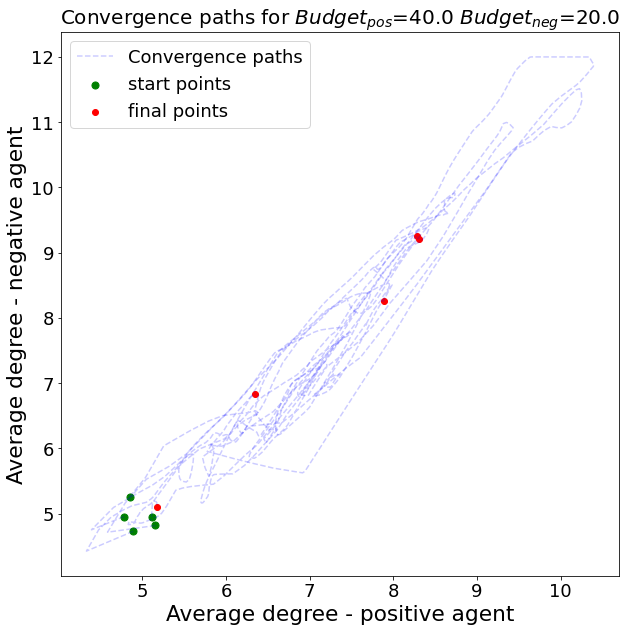

In [26]:
import matplotlib

n=1

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':(12,10),'axes.labelsize': 'large',
                           'axes.titlesize':20})

fig,ax=plt.subplots(figsize=(10,10))

for idx,run in enumerate(pos_degrees):
    
    ax.plot(run[::n],neg_degrees[idx][::n],label='Convergence paths',c='blue',linestyle='dashed',alpha=0.2)
    ax.set_xlabel('Average degree - positive agent')
    ax.set_ylabel('Average degree - negative agent')
    ax.scatter(run[0],neg_degrees[idx][0],c='green',label='start points',s=50)
    ax.scatter(run[-1],neg_degrees[idx][-1],c='red',label='final points')

    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax.legend(handout, lablout,loc='best')
    
        
pos_string = '$Budget_{pos}$'
neg_string = '$Budget_{neg}$'
ax.set_title(r'Convergence paths for {}={} {}={}'.format(pos_string,budget_pos,neg_string,budget_neg))

In [ ]:
beta_min = 0.25*beta_crit 
beta_max = 5*beta_crit 
# needs a wide range of beta to visibly include constant average degree intervals

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=50,endpoint=True,base=10)
y = np.zeros(len(beta_list))

normal_params = {'graph':G,'background_field':h,
                         'iim_iter':10000,'iim_tol_fac':1e-4,'fixed_point_iter':10000,
                         'step_size':9.0}

system = mf_ising_system(**normal_params) 
# EUREKA - STEP SIZE SEEMS TO BE THE SOLUTION - optimal seems to be 5.0
control_history=[]
for i,beta in enumerate(beta_list):
    control,_=system.MF_IIM(budget,beta)
    control_history.append(control)
    if i%10==0:
        print(i,beta)

print('FINISHED')    

In [ ]:
invalid = {"graph", "background_field"}
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

def params_name(params,invalid=invalid):
    params_string = [str(key)+str(entry) for key,entry in without_keys(params,invalid).items()]
    string='RealNet_Average_'+'_'.join(params_string)
    return string

params_name(normal_params)

In [ ]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


avs_degrees=np.zeros(len(control_history))
for it,control in enumerate(control_history):
    av_degree = average_degree(G,control,budget)
    avs_degrees[it]=av_degree

fig,ax = plt.subplots()

ax.plot(beta_list,avs_degrees)
ax.set_xscale(value='log')

ax.set_xticks([0.03,0.05,0.1,0.25,0.5])

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=min(avs_degrees),ymax=max(avs_degrees),linestyles='dashed',color='red',label='beta')
ax.set_xlabel(r'Interaction Strenght ($\beta$)')
ax.set_title('Distribution of influence \n'+ r'as a function of $\beta$')

#string_name='RealNet_Average'+{}
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/Masters_figures/'


#plt.savefig(path+params_name(normal_params)+'.png'.format(*[normal_params[x] for x in ['step_size','fixed_point_iter','iim_iter']]))
plt.show()
